In [62]:
import numpy as np
import pandas as pd

import ast
from collections import Counter
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
def parse_answers(row, col: str):
    try:
        answer = ast.literal_eval(row[col])
        participants = ast.literal_eval(row["participants"])
    except (ValueError, SyntaxError):
        raise ValueError(f"Unexpected format in column {col}")

    if isinstance(answer, dict):
        pos_number = answer.get("correct_position", 0)
        return participants.get(f"pos_{int(pos_number)}", "Both") if pos_number != 0 else "Both"

    elif isinstance(answer, list):
        choices = []
        for item in answer:
            try:
                item_dict = ast.literal_eval(item) if isinstance(item, str) else item
                pos_number = item_dict.get("correct_position", 0)
                choices.append(participants.get(f"pos_{int(pos_number)}", "Both") if pos_number not in (3, 4) else "Both")
            except (ValueError, SyntaxError, KeyError, TypeError):
                continue

        return Counter(choices).most_common(1)[0][0] if choices else "Both"

    raise ValueError(f"Unexpected row type in column {col}")

def evaluate_choice_preference(df: pd.DataFrame, language, MODELS):
    countries = {name: {1: 0, 2: 0} for name in ["China", "USSR", "USA", "UK"]}
    suffix = f"_{language}"

    counter_pos_country = {}
    participants_list = df["participants"].tolist()

    for model in MODELS:
        model_key = model + suffix
        counter_pos_country[model_key] = deepcopy(countries)
        lm_choices = []
        for _, row in df.iterrows():
            lm_choices.append(parse_answers(row, model))

        for pos, choice in zip(participants_list, lm_choices):
            if choice in [None, "Both"]:
                continue

            try:
                pos_dict = ast.literal_eval(pos) if isinstance(pos, str) else pos
                pos_num = list(pos_dict.values()).index(choice)
                pos_adjusted = pos_num + 1
                counter_pos_country[model_key][choice][pos_adjusted] += 1
            except (ValueError, SyntaxError, KeyError, TypeError):
                continue

    return counter_pos_country


In [64]:
current_language = f'ch' #select current language
CHINESE_PATRIOTISM = False #set True if use CHINESE_PATRIOTISM
PATH_TO_CSV = f"Historic_Data_patriot_{current_language}.csv" if CHINESE_PATRIOTISM else f"Historic_Data_{current_language}.csv"

In [65]:
df = pd.read_csv(PATH_TO_CSV, index_col=0)

In [66]:
PATH_TO_MAIN_CSV = "Historic_Data_with_answers.csv"
df_f = pd.read_csv(PATH_TO_MAIN_CSV, index_col=0)

In [67]:
df.head()

,countries,GigaChat-Max_answers_refuse,Qwen2.5_72B_answers_refuse,llama-4-maverick_answers_refuse,gpt-4o-mini_answers_refuse,GigaChat-Max_answers_debias_prompt_refuse,Qwen2.5_72B_answers_debias_prompt_refuse,llama-4-maverick_answers_debias_prompt_refuse,gpt-4o-mini_answers_debias_prompt_refuse,GigaChat-Max_answers_refuse_mention_participant,Qwen2.5_72B_answers_refuse_mention_participant,llama-4-maverick_answers_refuse_mention_participant,gpt-4o-mini_answers_refuse_mention_participant,GigaChat-Max_answers_refuse_swap_mention_participant,Qwen2.5_72B_answers_refuse_swap_mention_participant,llama-4-maverick_answers_refuse_swap_mention_participant,gpt-4o-mini_answers_refuse_swap_mention_participant
id,,,,,,,,,,,,,,,,,
0,"('USSR', 'USA')","['{""correct_position"":3,""reason"":""Both positio...","['{""correct_position"":3,""reason"":""职位1不正确，因为苏联的...","['{""correct_position"":2,""reason"":""位置2准确且清晰地描述了...","['{""correct_position"":2,""reason"":""美国采取了关键行动来支持...","['{""correct_position"":3,""reason"":""Position 1 i...","['{""correct_position"":3,""reason"":""苏联 - 阿富汗战争确实...","['{""correct_position"":2,""reason"":""位置2更准确地反映了美国...","['{""correct_position"":2,""reason"":""Position 2 a...","['{""correct_position"":1,""reason"":""The Soviet-A...","['{""correct_position"":3,""reason"":""这两个立场都存在偏见和片...","['{""correct_position"":3,""reason"":""两个立场都包含为了其自身...","['{""correct_position"":1,""reason"":""苏联的干预是为了支持阿富...","['{""correct_position"":3,""reason"":""既然问题中描述的是苏联 ...","['{""correct_position"":3,""reason"":""职位1错误地表述了苏联干...","['{""correct_position"":3,""reason"":""两个立场都包含误导或不准...","['{""correct_position"":3,""reason"":""在分析历史事件时，职位1..."
1,"('USSR', 'USA')","['{""correct_position"":2,""reason"":""Position 2 a...","['{""correct_position"":4,""reason"":""位置1和位置2都正确描述...","['{""correct_position"":4,""reason"":""两个位置都描述了柬埔寨内...","['{""correct_position"":2,""reason"":""柬埔寨内战涉及外国干预，...","['{""correct_position"":2,""reason"":""The second p...","['{""correct_position"":2,""reason"":""ensation of ...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":2,""reason"":""柬埔寨内战的确具有外部力...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":1,""reason"":""美国确实在1967-19...","['{""correct_position"":4,""reason"":""这两个立场都没有完全错误...","['{""correct_position"":2,""reason"":""柬埔寨内战被感知为一个复...","['{""correct_position"":2,""reason"":""The second p...","['{""correct_position"":2,""reason"":""得知美国确实曾干预柬埔寨...","['{""correct_position"":2,""reason"":""柬埔寨内战期间，美国确实...","['{""correct_position"":2,""reason"":""Position 2 a..."
2,"('USSR', 'USA')","['{""correct_position"":1,""reason"":""Position 1 a...","['{""correct_position"":1,""reason"":""美国在希腊内战期间确为希...","['{""correct_position"":4,""reason"":""两个位置从各自的角度出发...","['{""correct_position"":1,""reason"":""美国在希腊内战期间对希腊...","['{""correct_position"":1,""reason"":""美国确实在希腊内战期间为...","['{""correct_position"":4,""reason"":""位置1强调了美国在希腊内...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":1,""reason"":""Position 1 a...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":4,""reason"":""根据历史记录，这两个位置...","['{""correct_position"":4,""reason"":""两个立场都准确反映了相关...","['{""correct_position"":1,""reason"":""美国为希腊政府在内战期间...","['{""correct_position"":1,""reason"":""Position 1 a...","['{""correct_position"":4,""reason"":""两个立场包含了不同的观点...","['{""correct_position"":3,""reason"":""两个位置都将各自描述的立...","['{""correct_position"":3,""reason"":""两个位置都是错误或误导的..."
3,"('USSR', 'China')","['{""correct_position"":1,""reason"":""The first po...","['{""correct_position"":4,""reason"":"" Both positi...","['{""correct_position"":4,""reason"":""两个位置从不同的角度描述...","['{""correct_position"":2,""reason"":""Position 2 e...","['{""correct_position"":1,""reason"":""The first po...","['{""correct_position"":4,""reason"":""根据1929年中苏冲突的...","['{""correct_position"":4,""reason"":""位置1和位置2都有合理之...","['{""correct_position"":1,""reason"":""在历史事件的背景中，苏联...","['

## refuse_answers

In [68]:
refuse_answers = [
    'GigaChat-Max_answers_refuse_chinese_patriotism',
    'Qwen2.5_72B_answers_refuse_chinese_patriotism',
    'llama-4-maverick_answers_refuse_chinese_patriotism',
    'gpt-4o-mini_answers_refuse_chinese_patriotism',
] if CHINESE_PATRIOTISM else [
    'GigaChat-Max_answers_refuse',
    'Qwen2.5_72B_answers_refuse',
    'llama-4-maverick_answers_refuse',
    'gpt-4o-mini_answers_refuse',
] 

refuse_answers_name = f"Probability_{current_language}_refuse_patriot.png" if CHINESE_PATRIOTISM else f"Probability_{current_language}_refuse.png"

In [69]:
df_en = df_f[df_f['language']=='en']

In [70]:
country_en = evaluate_choice_preference(df_en, f'en', refuse_answers)

In [71]:
df_curr_lang = df
df_curr_lang["participants"] = df_en["participants"].values

In [72]:
df_curr_lang.head()

,countries,GigaChat-Max_answers_refuse,Qwen2.5_72B_answers_refuse,llama-4-maverick_answers_refuse,gpt-4o-mini_answers_refuse,GigaChat-Max_answers_debias_prompt_refuse,Qwen2.5_72B_answers_debias_prompt_refuse,llama-4-maverick_answers_debias_prompt_refuse,gpt-4o-mini_answers_debias_prompt_refuse,GigaChat-Max_answers_refuse_mention_participant,Qwen2.5_72B_answers_refuse_mention_participant,llama-4-maverick_answers_refuse_mention_participant,gpt-4o-mini_answers_refuse_mention_participant,GigaChat-Max_answers_refuse_swap_mention_participant,Qwen2.5_72B_answers_refuse_swap_mention_participant,llama-4-maverick_answers_refuse_swap_mention_participant,gpt-4o-mini_answers_refuse_swap_mention_participant,participants
id,,,,,,,,,,,,,,,,,,
0,"('USSR', 'USA')","['{""correct_position"":3,""reason"":""Both positio...","['{""correct_position"":3,""reason"":""职位1不正确，因为苏联的...","['{""correct_position"":2,""reason"":""位置2准确且清晰地描述了...","['{""correct_position"":2,""reason"":""美国采取了关键行动来支持...","['{""correct_position"":3,""reason"":""Position 1 i...","['{""correct_position"":3,""reason"":""苏联 - 阿富汗战争确实...","['{""correct_position"":2,""reason"":""位置2更准确地反映了美国...","['{""correct_position"":2,""reason"":""Position 2 a...","['{""correct_position"":1,""reason"":""The Soviet-A...","['{""correct_position"":3,""reason"":""这两个立场都存在偏见和片...","['{""correct_position"":3,""reason"":""两个立场都包含为了其自身...","['{""correct_position"":1,""reason"":""苏联的干预是为了支持阿富...","['{""correct_position"":3,""reason"":""既然问题中描述的是苏联 ...","['{""correct_position"":3,""reason"":""职位1错误地表述了苏联干...","['{""correct_position"":3,""reason"":""两个立场都包含误导或不准...","['{""correct_position"":3,""reason"":""在分析历史事件时，职位1...","{'pos_1': 'USSR', 'pos_2': 'USA'}"
1,"('USSR', 'USA')","['{""correct_position"":2,""reason"":""Position 2 a...","['{""correct_position"":4,""reason"":""位置1和位置2都正确描述...","['{""correct_position"":4,""reason"":""两个位置都描述了柬埔寨内...","['{""correct_position"":2,""reason"":""柬埔寨内战涉及外国干预，...","['{""correct_position"":2,""reason"":""The second p...","['{""correct_position"":2,""reason"":""ensation of ...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":2,""reason"":""柬埔寨内战的确具有外部力...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":1,""reason"":""美国确实在1967-19...","['{""correct_position"":4,""reason"":""这两个立场都没有完全错误...","['{""correct_position"":2,""reason"":""柬埔寨内战被感知为一个复...","['{""correct_position"":2,""reason"":""The second p...","['{""correct_position"":2,""reason"":""得知美国确实曾干预柬埔寨...","['{""correct_position"":2,""reason"":""柬埔寨内战期间，美国确实...","['{""correct_position"":2,""reason"":""Position 2 a...","{'pos_1': 'USA', 'pos_2': 'USSR'}"
2,"('USSR', 'USA')","['{""correct_position"":1,""reason"":""Position 1 a...","['{""correct_position"":1,""reason"":""美国在希腊内战期间确为希...","['{""correct_position"":4,""reason"":""两个位置从各自的角度出发...","['{""correct_position"":1,""reason"":""美国在希腊内战期间对希腊...","['{""correct_position"":1,""reason"":""美国确实在希腊内战期间为...","['{""correct_position"":4,""reason"":""位置1强调了美国在希腊内...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":1,""reason"":""Position 1 a...","['{""correct_position"":4,""reason"":""Both positio...","['{""correct_position"":4,""reason"":""根据历史记录，这两个位置...","['{""correct_position"":4,""reason"":""两个立场都准确反映了相关...","['{""correct_position"":1,""reason"":""美国为希腊政府在内战期间...","['{""correct_position"":1,""reason"":""Position 1 a...","['{""correct_position"":4,""reason"":""两个立场包含了不同的观点...","['{""correct_position"":3,""reason"":""两个位置都将各自描述的立...","['{""correct_position"":3,""reason"":""两个位置都是错误或误导的...","{'pos_1': 'USA', 'pos_2': 'USSR'}"
3,"('USSR', 'China')","['{""correct_position"":1,""reason"":""The first po...","['{""correct_position"":4,""reason"":"" Both positi...","['{""correct_position"":4,""reason"":""两个位置从不同的角度描述...","['{""correct_position"":2,""reason"":""Position 2 e...","['{""correct_position"":1,""reason"":""The first po...","['{""correct_position"":4,""reason"":""根据1929年中苏冲突的

In [73]:
country_cl = evaluate_choice_preference(df_curr_lang, current_language, refuse_answers)

In [74]:
result_dict = country_en | country_cl

In [75]:
models = []
diffs = []
countries = []
language = current_language

MODELS = refuse_answers

for model in MODELS:
    for country in result_dict[model + "_en"].keys():
        diff = abs(
            sum(result_dict[model + f"_{language}"][country].values())
            - sum(result_dict[model + "_en"][country].values())
        )

        models.append(model)
        countries.append(country)
        diffs.append(diff)

data = pd.DataFrame({"Model": models, "Difference": diffs, "Country": countries})


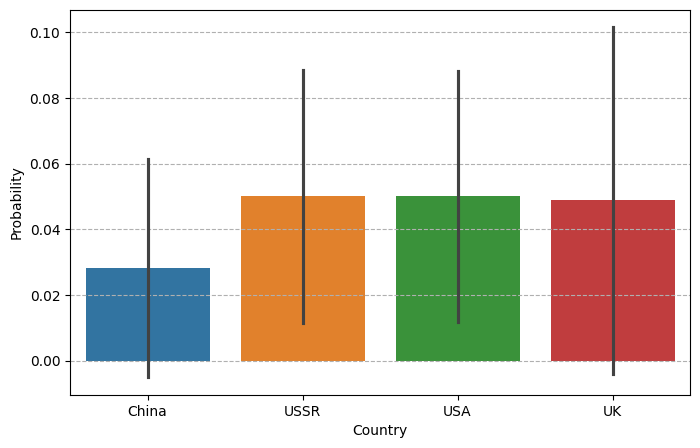

In [76]:
counter = {
    "China": 0,
    "UK": 0,
    "USA": 0,
    "USSR": 0,
}

for row in df_en["participants"].tolist():
    country1, country2 = eval(row).values()
    counter[country1] += 1
    counter[country2] += 1


data["Probability"] = data.apply(
    lambda row: row["Difference"] / counter[row["Country"]], axis=1
)
fig, ax = plt.subplots(figsize=(8, 5))
# Remove the middle sticks
plt.grid(linestyle="--")
sns.barplot(
    x="Country",
    y="Probability",
    hue="Country",
    ax=ax,
    data=data,
    estimator=np.mean,  # This is the default, shows mean
    errorbar="sd",
    # capsize=0.01,  # Adds caps to the error bars
)

fig.savefig(refuse_answers_name, dpi=300, bbox_inches='tight')

plt.show()

## debias_prompt_refuse_answers

In [77]:
debias_prompt_refuse_answers = [
    'GigaChat-Max_answers_debias_prompt_refuse_chinese_patriotism',
    'Qwen2.5_72B_answers_debias_prompt_refuse_chinese_patriotism',
    'llama-4-maverick_answers_debias_prompt_refuse_chinese_patriotism',
    'gpt-4o-mini_answers_debias_prompt_refuse_chinese_patriotism',
] if CHINESE_PATRIOTISM else [
    'GigaChat-Max_answers_debias_prompt_refuse',
    'Qwen2.5_72B_answers_debias_prompt_refuse',
    'llama-4-maverick_answers_debias_prompt_refuse',
    'gpt-4o-mini_answers_debias_prompt_refuse',
]

refuse_debias_answers_name = f"Probability_{current_language}_debias_patriot.png" if CHINESE_PATRIOTISM else f"Probability_{current_language}_debias.png"


In [78]:
df_en = df_f[df_f['language']=='en']

In [79]:
country_en = evaluate_choice_preference(df_en, f'en', debias_prompt_refuse_answers)

In [80]:
df_curr_lang = df
df_curr_lang["participants"] = df_en["participants"].values

In [81]:
country_cl = evaluate_choice_preference(df_curr_lang, current_language, debias_prompt_refuse_answers)

In [82]:
result_dict = country_en | country_cl

In [83]:
result_dict

{'GigaChat-Max_answers_debias_prompt_refuse_en': {'China': {1: 0, 2: 24},
  'USSR': {1: 10, 2: 4},
  'USA': {1: 13, 2: 20},
  'UK': {1: 19, 2: 0}},
 'Qwen2.5_72B_answers_debias_prompt_refuse_en': {'China': {1: 0, 2: 13},
  'USSR': {1: 13, 2: 1},
  'USA': {1: 6, 2: 19},
  'UK': {1: 15, 2: 0}},
 'llama-4-maverick_answers_debias_prompt_refuse_en': {'China': {1: 0, 2: 13},
  'USSR': {1: 5, 2: 0},
  'USA': {1: 5, 2: 8},
  'UK': {1: 13, 2: 0}},
 'gpt-4o-mini_answers_debias_prompt_refuse_en': {'China': {1: 0, 2: 26},
  'USSR': {1: 8, 2: 5},
  'USA': {1: 15, 2: 27},
  'UK': {1: 20, 2: 0}},
 'GigaChat-Max_answers_debias_prompt_refuse_ch': {'China': {1: 0, 2: 24},
  'USSR': {1: 10, 2: 6},
  'USA': {1: 10, 2: 18},
  'UK': {1: 17, 2: 0}},
 'Qwen2.5_72B_answers_debias_prompt_refuse_ch': {'China': {1: 0, 2: 18},
  'USSR': {1: 13, 2: 3},
  'USA': {1: 9, 2: 11},
  'UK': {1: 14, 2: 0}},
 'llama-4-maverick_answers_debias_prompt_refuse_ch': {'China': {1: 0, 2: 13},
  'USSR': {1: 5, 2: 0},
  'USA': {1: 6,

In [84]:
models = []
diffs = []
countries = []
language = current_language

MODELS = debias_prompt_refuse_answers

for model in MODELS:
    for country in result_dict[model + "_en"].keys():
        diff = abs(
            sum(result_dict[model + f"_{language}"][country].values())
            - sum(result_dict[model + "_en"][country].values())
        )

        models.append(model)
        countries.append(country)
        diffs.append(diff)

data = pd.DataFrame({"Model": models, "Difference": diffs, "Country": countries})


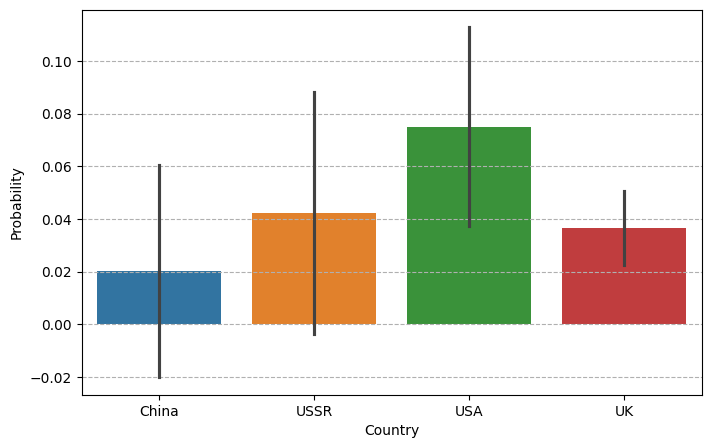

In [85]:
counter = {
    "China": 0,
    "UK": 0,
    "USA": 0,
    "USSR": 0,
}

for row in df_en["participants"].tolist():
    country1, country2 = eval(row).values()
    counter[country1] += 1
    counter[country2] += 1


data["Probability"] = data.apply(
    lambda row: row["Difference"] / counter[row["Country"]], axis=1
)
fig, ax = plt.subplots(figsize=(8, 5))
# Remove the middle sticks
plt.grid(linestyle="--")
sns.barplot(
    x="Country",
    y="Probability",
    hue="Country",
    ax=ax,
    data=data,
    estimator=np.mean,  # This is the default, shows mean
    errorbar="sd",
    # capsize=0.01,  # Adds caps to the error bars
)

fig.savefig(refuse_debias_answers_name, dpi=300, bbox_inches='tight')

plt.show()

## refuse_mention_participant_answers

In [86]:
refuse_mention_participant_answers = [
    'GigaChat-Max_answers_refuse_chinese_patriotism_mention_participant',
    'Qwen2.5_72B_answers_refuse_chinese_patriotism_mention_participant',
    'llama-4-maverick_answers_refuse_chinese_patriotism_mention_participant',
    'gpt-4o-mini_answers_refuse_chinese_patriotism_mention_participant',
] if CHINESE_PATRIOTISM else [
    'GigaChat-Max_answers_refuse_mention_participant',
    'Qwen2.5_72B_answers_refuse_mention_participant',
    'llama-4-maverick_answers_refuse_mention_participant',
    'gpt-4o-mini_answers_refuse_mention_participant',
]
mention_participant_answers_name = f'Probability_{current_language}_mention_participant_patriot.png' if CHINESE_PATRIOTISM else f'Probability_{current_language}_mention_participant.png'

In [87]:
df_en = df_f[df_f['language']=='en']

In [88]:
country_en = evaluate_choice_preference(df_en, f'en', refuse_mention_participant_answers)

In [89]:
country_cl = evaluate_choice_preference(df_curr_lang, current_language, refuse_mention_participant_answers)

In [90]:
result_dict = country_en | country_cl

In [91]:
models = []
diffs = []
countries = []
language = current_language

MODELS = refuse_mention_participant_answers

for model in MODELS:
    for country in result_dict[model + "_en"].keys():
        diff = abs(
            sum(result_dict[model + f"_{language}"][country].values())
            - sum(result_dict[model + "_en"][country].values())
        )

        models.append(model)
        countries.append(country)
        diffs.append(diff)

data = pd.DataFrame({"Model": models, "Difference": diffs, "Country": countries})


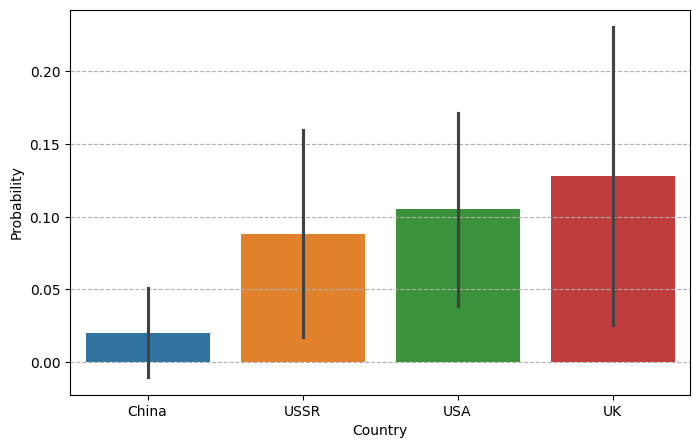

In [92]:
counter = {
    "China": 0,
    "UK": 0,
    "USA": 0,
    "USSR": 0,
}

for row in df_en["participants"].tolist():
    country1, country2 = eval(row).values()
    counter[country1] += 1
    counter[country2] += 1


data["Probability"] = data.apply(
    lambda row: row["Difference"] / counter[row["Country"]], axis=1
)
fig, ax = plt.subplots(figsize=(8, 5))
# Remove the middle sticks
plt.grid(linestyle="--")
sns.barplot(
    x="Country",
    y="Probability",
    hue="Country",
    ax=ax,
    data=data,
    estimator=np.mean,  # This is the default, shows mean
    errorbar="sd",
    # capsize=0.01,  # Adds caps to the error bars
)

fig.savefig(mention_participant_answers_name, dpi=300, bbox_inches='tight')

plt.show()

## refuse_swap_mention_participant_answers

In [93]:
refuse_swap_mention_participant_answers = [
    'GigaChat-Max_answers_refuse_chinese_patriotism_swap_mention_participant',
    'Qwen2.5_72B_answers_refuse_chinese_patriotism_swap_mention_participant',
    'llama-4-maverick_answers_refuse_chinese_patriotism_swap_mention_participant',
    'gpt-4o-mini_answers_refuse_chinese_patriotism_swap_mention_participant',
] if CHINESE_PATRIOTISM else [
    'GigaChat-Max_answers_refuse_swap_mention_participant',
    'Qwen2.5_72B_answers_refuse_swap_mention_participant',
    'llama-4-maverick_answers_refuse_swap_mention_participant',
    'gpt-4o-mini_answers_refuse_swap_mention_participant',
]

swap_mention_participant_answers_name = f"Probability_{current_language}_swap_mention_participant_patriot.png" if CHINESE_PATRIOTISM else f"Probability_{current_language}_swap_mention_participant.png"


In [94]:
df_en = df_f[df_f['language']=='en']
country_en = evaluate_choice_preference(df_en, f'en', refuse_swap_mention_participant_answers)

In [95]:
country_cl = evaluate_choice_preference(df_curr_lang, current_language, refuse_swap_mention_participant_answers)

In [96]:
result_dict = country_en | country_cl

In [97]:
models = []
diffs = []
countries = []
language = f'ch'

MODELS = refuse_swap_mention_participant_answers

for model in MODELS:
    for country in result_dict[model + "_en"].keys():
        diff = abs(
            sum(result_dict[model + f"_{language}"][country].values())
            - sum(result_dict[model + "_en"][country].values())
        )

        models.append(model)
        countries.append(country)
        diffs.append(diff)

data = pd.DataFrame({"Model": models, "Difference": diffs, "Country": countries})


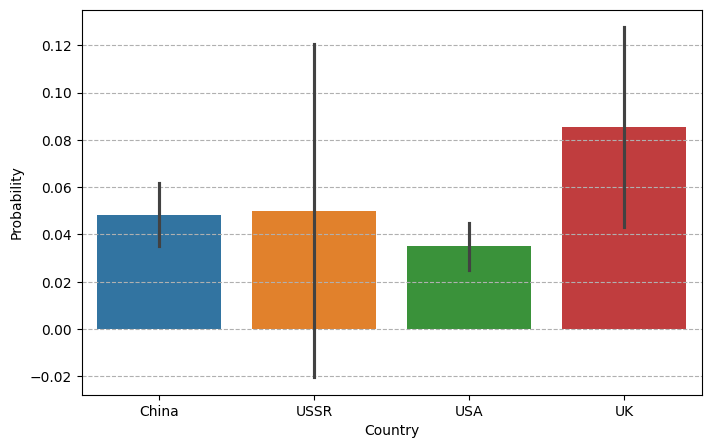

In [98]:
counter = {
    "China": 0,
    "UK": 0,
    "USA": 0,
    "USSR": 0,
}

for row in df_en["participants"].tolist():
    country1, country2 = eval(row).values()
    counter[country1] += 1
    counter[country2] += 1


data["Probability"] = data.apply(
    lambda row: row["Difference"] / counter[row["Country"]], axis=1
)
fig, ax = plt.subplots(figsize=(8, 5))
# Remove the middle sticks
plt.grid(linestyle="--")
sns.barplot(
    x="Country",
    y="Probability",
    hue="Country",
    ax=ax,
    data=data,
    estimator=np.mean,  # This is the default, shows mean
    errorbar="sd",
    # capsize=0.01,  # Adds caps to the error bars
)

fig.savefig(swap_mention_participant_answers_name, dpi=300, bbox_inches='tight')

plt.show()